# Introduction

In this project, we will build a neural network to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking our models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Install requirements
!python -m pip install -r requirements.txt

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
print(torch)
import torch.nn.functional as F

from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets

import torchvision.transforms as T
from torchsummary import summary
from tqdm import tqdm
# from sklearn.model_selection import train_test_split

%matplotlib inline

<module 'torch' from 'c:\\Users\\Medhat\\Anaconda3\\envs\\torch\\lib\\site-packages\\torch\\__init__.py'>


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, torch.cuda.device_count()

(device(type='cuda'), 1)

In [5]:
import multiprocessing

# number of subprocesses to use for data loading
# We set this equal to the number of CPUs available
# in this machine
n_workers = multiprocessing.cpu_count()

## Data Loading & Preprocessing

In [145]:
# Hyperparameters
batch_size = 100
n_epochs = 20
learning_rate = 1e-3

# transforms pipeline
transform = T.Compose([
    # This transforms takes a np.array or a PIL image of integers
    # in the range 0-255 and transforms it to a float tensor in the
    # range 0.0 - 1.0
    T.ToTensor(),
    # This then renormalize the tensor to be between -1.0 and 1.0,
    # which is a better range for modern activation functions like Relu
    T.Normalize((0.5), (0.5))
])

# training and test sets
trainval_data = datasets.MNIST(root="data", download=True, train=True, transform=transform)
test_data = datasets.MNIST(root="data", download=True, train=False, transform=transform)

# Split in train and validation
# NOTE: we set the generator with a fixed random seed for reproducibility
train_len = int(len(trainval_data) * 0.85)
val_len = len(trainval_data) - train_len

# create separate copies for training and validation datasets
# train_data, val_data = train_test_split(orig_data, test_size=0.2, random_state=42)
train_data, val_data = random_split(trainval_data, [train_len, val_len], generator=torch.Generator().manual_seed(42))

# train, test and val loaders 
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=n_workers)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True, num_workers=n_workers)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False, num_workers=n_workers)

print(f"Using {train_len} examples for training.")
print(f"Using {val_len} examples for validation.")
print(f"Using {len(test_loader.dataset)} examples for testing.")

Using 51000 examples for training.
Using 9000 examples for validation.
Using 10000 examples for testing.


## EXPLORATORY DATA ANALYSIS


In [146]:
## This cell contains a function for showing 5 images from a dataloader
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    
    for i in range(5):
        print(int(labels[i].detach()))
        
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

5


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001C86E492440>
Traceback (most recent call last):
  File "c:\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "c:\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


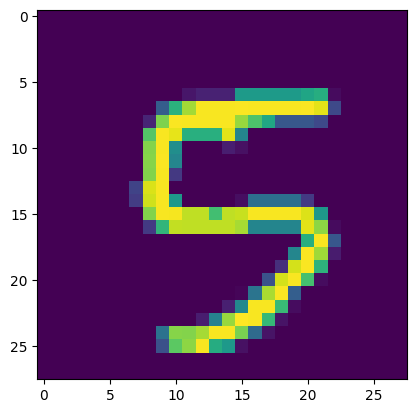

2


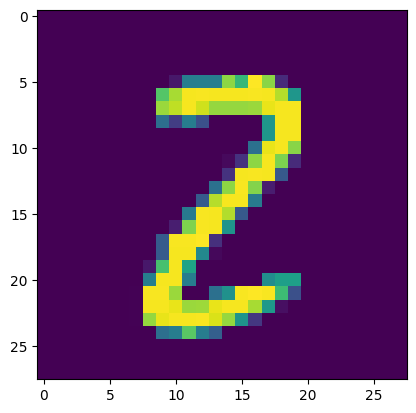

1


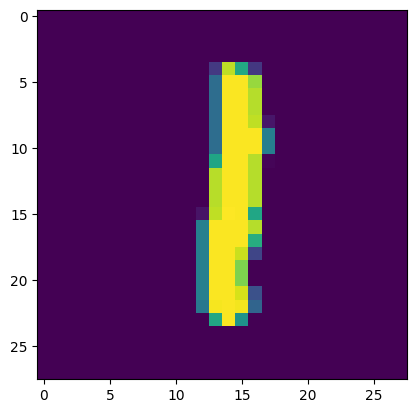

6


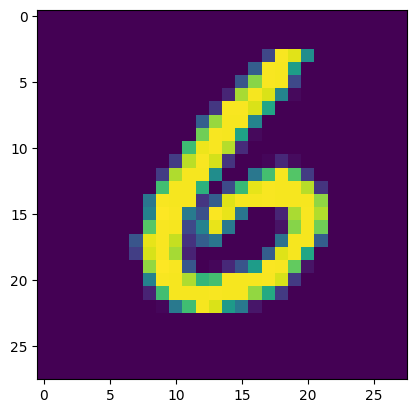

7


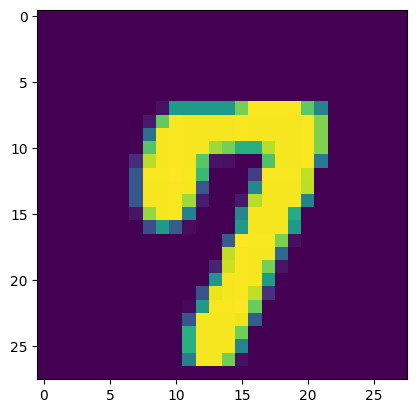

In [147]:
show5(test_loader)

In [148]:
len(train_loader.dataset), len(test_loader.dataset), len(val_loader.dataset)

(51000, 10000, 9000)

## Build the Neural Network

In [149]:
class DigitNet(nn.Module):
    def __init__(self, in_features = 28 * 28, out_features = 10):
        super(DigitNet, self).__init__()
        
        hidden_1 = 120
        hidden_2 = 84
        
        # Linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(in_features, out_features=hidden_1)
        # Linear layer (hidden_1 -> hidden_2)
        self.fc2 = nn.Linear(in_features=hidden_1, out_features=hidden_2)
        # Linear layer (hidden_2 -> hidden_3)
        self.fc3 = nn.Linear(in_features=hidden_2, out_features=out_features)
        
    def forward(self, x):
        x = torch.flatten(x, 1) # or x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)
        
net = DigitNet()
net.to(device) # prints topology of the network

DigitNet(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Check net parameters & layers 

In [150]:
summary(net, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 120]          94,200
            Linear-2                   [-1, 84]          10,164
            Linear-3                   [-1, 10]             850
Total params: 105,214
Trainable params: 105,214
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.40
Estimated Total Size (MB): 0.41
----------------------------------------------------------------


## Specify a loss function and an optimizer

In [151]:
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [152]:
criterion = nn.CrossEntropyLoss()

## Training and Evaluation loop with early stopping

In [153]:
def train(net, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, criterion=criterion, epochs=n_epochs):
    # track losses for plotting
    train_losses = []
    val_losses = []
    
    best_val_loss = float("inf")
    no_improvement_count = 0
    patience = 3
    
    for epoch in range(epochs):
        net.train()
        
        train_loss = 0.0
        train_correct = 0.0
        for batch_idx, (data, target) in tqdm(
            enumerate(train_loader),
            desc="Training",
            total=len(train_loader),
            leave=True,
            ncols=80
        ):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = net(data)
            
            loss = criterion(output, target)
            loss.backward() # calculate gradients
            optimizer.step() # apply weight update
            
            _, preds = torch.max(output.data, 1)
            train_correct += (preds == target).sum().item()
            train_loss += loss.item()
            
        accuracy = train_correct/len(train_loader)
        avg_loss = train_loss/len(train_loader)
        train_losses.append(avg_loss)  # Store training loss
        print(f'Epoch {epoch + 1} training accuracy: {accuracy:.2f}% training loss: {avg_loss:.5f}')
        
        # Validation on validation set
        val_loss, val_accuracy = evaluate(net, val_loader, criterion)
        val_losses.append(val_loss) # Store val loss
        print(f'Epoch {epoch + 1} val accuracy: {val_accuracy:.2f}% val loss: {val_loss:.5f}')
        
        # Early stopping
        if(val_loss < best_val_loss):
            best_val_loss = val_loss
            no_improvement_count = 0 # reset
        else:
            no_improvement_count += 1
            if(no_improvement_count >= patience):
                print(f'Early stopping after {epoch + 1} epochs with no improvement.')
                break # stop training
    return train_losses, val_losses

def evaluate(net, val_loader, criterion=criterion):
    net.eval()
    val_correct = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(
            enumerate(val_loader),
            desc="Validating",
            total=len(val_loader),
            leave=True,
            ncols=80
        ):
            data, target = data.to(device), target.to(device)

            output = net(data)

            loss = criterion(output, target)
            _, preds = torch.max(output.data, 1)

            val_correct += (preds == target).sum().item()
            val_loss += loss.item()
            
        accuracy = val_correct/len(val_loader)
        avg_loss = val_loss/len(val_loader)
        
        return avg_loss, accuracy 

## Model test accuracy and loss function

In [154]:
def test(net, data_loader=test_loader, criterion=criterion):
        net.eval()
        test_loss = 0.0
        test_correct = 0.0
        
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs.data, 1)
                test_correct += (preds == labels).sum().item()
                test_loss += loss.item()
                
        accuracy = test_correct/len(test_loader)
        avg_loss = test_loss/len(test_loader)
        
        print(f'Test accuracy: {accuracy:.2f}% test loss: {avg_loss:.5f}')

## Plot training and evaluation losses per epoch 

In [155]:
def plot_losses(train_losses, val_losses):
    epochs = len(train_losses)
    x_ticks = np.arange(1, epochs + 1)
    
    plt.plot(x_ticks, train_losses, label="Training Loss")
    plt.plot(x_ticks, val_losses, label="Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(x_ticks)
    plt.legend()
    plt.show()

## Running the Neural Network

In [156]:
%%time
train_losses, val_losses = train(net, epochs=n_epochs)

Training: 100%|███████████████████████████████| 510/510 [00:05<00:00, 88.57it/s]


Epoch 1 training accuracy: 86.89% training loss: 0.45294


Validating: 100%|███████████████████████████████| 90/90 [00:16<00:00,  5.41it/s]


Epoch 1 val accuracy: 91.68% val loss: 0.28495


Training: 100%|███████████████████████████████| 510/510 [00:05<00:00, 94.78it/s]


Epoch 2 training accuracy: 93.38% training loss: 0.22204


Validating: 100%|███████████████████████████████| 90/90 [00:17<00:00,  5.29it/s]


Epoch 2 val accuracy: 94.30% val loss: 0.18979


Training: 100%|███████████████████████████████| 510/510 [00:07<00:00, 72.36it/s]


Epoch 3 training accuracy: 95.11% training loss: 0.15877


Validating: 100%|███████████████████████████████| 90/90 [00:16<00:00,  5.40it/s]


Epoch 3 val accuracy: 95.42% val loss: 0.15814


Training: 100%|███████████████████████████████| 510/510 [00:05<00:00, 97.19it/s]


Epoch 4 training accuracy: 96.23% training loss: 0.12484


Validating: 100%|███████████████████████████████| 90/90 [00:16<00:00,  5.56it/s]


Epoch 4 val accuracy: 95.60% val loss: 0.14538


Training: 100%|███████████████████████████████| 510/510 [00:05<00:00, 97.17it/s]


Epoch 5 training accuracy: 96.69% training loss: 0.10639


Validating: 100%|███████████████████████████████| 90/90 [00:11<00:00,  7.93it/s]


Epoch 5 val accuracy: 96.04% val loss: 0.13284


Training: 100%|███████████████████████████████| 510/510 [00:05<00:00, 94.90it/s]


Epoch 6 training accuracy: 97.11% training loss: 0.09345


Validating: 100%|███████████████████████████████| 90/90 [00:16<00:00,  5.53it/s]


Epoch 6 val accuracy: 96.64% val loss: 0.11385


Training: 100%|███████████████████████████████| 510/510 [00:05<00:00, 85.66it/s]


Epoch 7 training accuracy: 97.47% training loss: 0.08065


Validating: 100%|███████████████████████████████| 90/90 [00:14<00:00,  6.13it/s]


Epoch 7 val accuracy: 96.73% val loss: 0.10784


Training: 100%|██████████████████████████████| 510/510 [00:04<00:00, 121.72it/s]


Epoch 8 training accuracy: 97.77% training loss: 0.07048


Validating: 100%|███████████████████████████████| 90/90 [00:08<00:00, 10.44it/s]


Epoch 8 val accuracy: 96.86% val loss: 0.11097


Training: 100%|██████████████████████████████| 510/510 [00:04<00:00, 120.01it/s]


Epoch 9 training accuracy: 97.79% training loss: 0.06744


Validating: 100%|███████████████████████████████| 90/90 [00:09<00:00,  9.12it/s]


Epoch 9 val accuracy: 96.96% val loss: 0.11105


Training: 100%|██████████████████████████████| 510/510 [00:04<00:00, 112.06it/s]


Epoch 10 training accuracy: 98.12% training loss: 0.05779


Validating: 100%|███████████████████████████████| 90/90 [00:08<00:00, 10.11it/s]


Epoch 10 val accuracy: 97.39% val loss: 0.09288


Training: 100%|██████████████████████████████| 510/510 [00:04<00:00, 115.12it/s]


Epoch 11 training accuracy: 98.31% training loss: 0.05195


Validating: 100%|███████████████████████████████| 90/90 [00:08<00:00, 10.87it/s]


Epoch 11 val accuracy: 96.92% val loss: 0.10408


Training: 100%|██████████████████████████████| 510/510 [00:04<00:00, 109.61it/s]


Epoch 12 training accuracy: 98.39% training loss: 0.04980


Validating: 100%|███████████████████████████████| 90/90 [00:09<00:00,  9.58it/s]


Epoch 12 val accuracy: 97.01% val loss: 0.10175


Training: 100%|██████████████████████████████| 510/510 [00:04<00:00, 122.65it/s]


Epoch 13 training accuracy: 98.55% training loss: 0.04335


Validating: 100%|███████████████████████████████| 90/90 [00:09<00:00,  9.65it/s]

Epoch 13 val accuracy: 96.93% val loss: 0.10311
Early stopping after 13 epochs with no improvement.
CPU times: total: 24.2 s
Wall time: 17min 39s


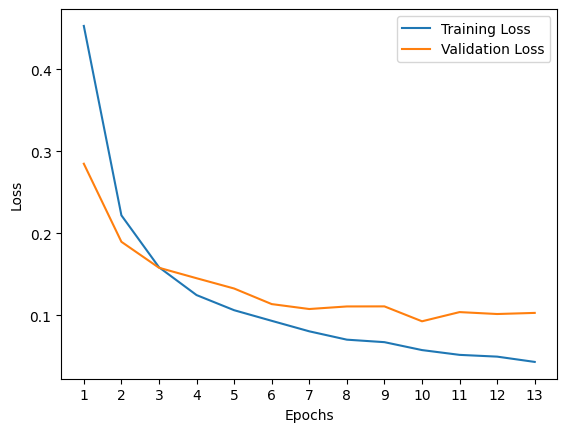

In [157]:
plot_losses(train_losses, val_losses)

## Testing results

In [158]:
test(net)

Test accuracy: 97.27% test loss: 0.09285


## Saving the model

In [159]:
torch.save(net.state_dict(), 'DigitNet.pt')

In [160]:
# save as torchscript
scripted = torch.jit.script(net)
torch.jit.save(scripted, "DigitNetTS.pt") # py-torch-script